In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# If we are on colab: this clones the repo and installs the dependencies
from pathlib import Path
if Path.cwd().name != 'LightGlue':
  !git clone --quiet https://github.com/cvg/LightGlue/
  %cd LightGlue
  !pip install --progress-bar off --quiet -e .

from lightglue import LightGlue, DISK
from lightglue.utils import load_image, rbd
from lightglue import viz2d
import torch
torch.set_grad_enabled(False);
images = Path('assets')

/content/LightGlue
  Preparing metadata (setup.py) ... done


## Define Image processor
To use feature extract


In [3]:
from pathlib import Path
import torch
import kornia
import cv2
import numpy as np
from typing import Union, List, Optional, Callable, Tuple
import collections.abc as collections
from types import SimpleNamespace


class ImagePreprocessor:
    default_conf = {
        'resize': None,  # target edge length, None for no resizing
        'side': 'long',
        'interpolation': 'bilinear',
        'align_corners': None,
        'antialias': True,
        'grayscale': False,  # convert rgb to grayscale
    }

    def __init__(self, **conf) -> None:
        super().__init__()
        self.conf = {**self.default_conf, **conf}
        self.conf = SimpleNamespace(**self.conf)

    def __call__(self, img: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        """Resize and preprocess an image, return image and resize scale"""
        h, w = img.shape[-2:]
        if self.conf.resize is not None:
            img = kornia.geometry.transform.resize(
                img, self.conf.resize, side=self.conf.side,
                antialias=self.conf.antialias,
                align_corners=self.conf.align_corners)
        scale = torch.Tensor([img.shape[-1] / w, img.shape[-2] / h]).to(img)
        if self.conf.grayscale and img.shape[-3] == 3:
            img = kornia.color.rgb_to_grayscale(img)
        elif not self.conf.grayscale and img.shape[-3] == 1:
            img = kornia.color.grayscale_to_rgb(img)
        return img, scale


def map_tensor(input_, func: Callable):
    string_classes = (str, bytes)
    if isinstance(input_, string_classes):
        return input_
    elif isinstance(input_, collections.Mapping):
        return {k: map_tensor(sample, func) for k, sample in input_.items()}
    elif isinstance(input_, collections.Sequence):
        return [map_tensor(sample, func) for sample in input_]
    elif isinstance(input_, torch.Tensor):
        return func(input_)
    else:
        return input_


def batch_to_device(batch: dict, device: str = 'cpu',
                    non_blocking: bool = True):
    """Move batch (dict) to device"""
    def _func(tensor):
        return tensor.to(device=device, non_blocking=non_blocking).detach()
    return map_tensor(batch, _func)


def rbd(data: dict) -> dict:
    """Remove batch dimension from elements in data"""
    return {k: v[0] if isinstance(v, (torch.Tensor, np.ndarray, list)) else v
            for k, v in data.items()}


def read_image(path: Path, grayscale: bool = False) -> np.ndarray:
    """Read an image from path as RGB or grayscale"""
    if not Path(path).exists():
        raise FileNotFoundError(f'No image at path {path}.')
    mode = cv2.IMREAD_GRAYSCALE if grayscale else cv2.IMREAD_COLOR
    image = cv2.imread(str(path), mode)
    if image is None:
        raise IOError(f'Could not read image at {path}.')
    if not grayscale:
        image = image[..., ::-1]
    return image


def numpy_image_to_torch(image: np.ndarray) -> torch.Tensor:
    """Normalize the image tensor and reorder the dimensions."""
    if image.ndim == 3:
        image = image.transpose((2, 0, 1))  # HxWxC to CxHxW
    elif image.ndim == 2:
        image = image[None]  # add channel axis
    else:
        raise ValueError(f'Not an image: {image.shape}')
    return torch.tensor(image / 255., dtype=torch.float)


def resize_image(image: np.ndarray, size: Union[List[int], int],
                 fn: str = 'max', interp: Optional[str] = 'area',
                 ) -> np.ndarray:
    """Resize an image to a fixed size, or according to max or min edge."""
    h, w = image.shape[:2]

    fn = {'max': max, 'min': min}[fn]
    if isinstance(size, int):
        scale = size / fn(h, w)
        h_new, w_new = int(round(h*scale)), int(round(w*scale))
        scale = (w_new / w, h_new / h)
    elif isinstance(size, (tuple, list)):
        h_new, w_new = size
        scale = (w_new / w, h_new / h)
    else:
        raise ValueError(f'Incorrect new size: {size}')
    mode = {
        'linear': cv2.INTER_LINEAR,
        'cubic': cv2.INTER_CUBIC,
        'nearest': cv2.INTER_NEAREST,
        'area': cv2.INTER_AREA}[interp]
    return cv2.resize(image, (w_new, h_new), interpolation=mode), scale


def load_image(path: Path, resize: int = None, **kwargs) -> torch.Tensor:
    image = read_image(path)
    if resize is not None:
        image, _ = resize_image(image, resize, **kwargs)
    return numpy_image_to_torch(image)


def match_pair(extractor, matcher,
               image0: torch.Tensor, image1: torch.Tensor,
               device: str = 'cpu', **preprocess):
    """Match a pair of images (image0, image1) with an extractor and matcher"""
    feats0 = extractor.extract(image0, **preprocess)
    feats1 = extractor.extract(image1, **preprocess)
    matches01 = matcher({'image0': feats0, 'image1': feats1})
    data = [feats0, feats1, matches01]
    # remove batch dim and move to target device
    feats0, feats1, matches01 = [batch_to_device(rbd(x), device) for x in data]
    return feats0, feats1, matches01

## Define Feature Extractor
To match features


In [7]:
import torch
from torch import nn


def simple_nms(scores, nms_radius: int):
    """ Fast Non-maximum suppression to remove nearby points """
    assert (nms_radius >= 0)

    def max_pool(x):
        return torch.nn.functional.max_pool2d(
            x, kernel_size=nms_radius*2+1, stride=1, padding=nms_radius)

    zeros = torch.zeros_like(scores)
    max_mask = scores == max_pool(scores)
    for _ in range(2):
        supp_mask = max_pool(max_mask.float()) > 0
        supp_scores = torch.where(supp_mask, zeros, scores)
        new_max_mask = supp_scores == max_pool(supp_scores)
        max_mask = max_mask | (new_max_mask & (~supp_mask))
    return torch.where(max_mask, scores, zeros)


def top_k_keypoints(keypoints, scores, k):
    if k >= len(keypoints):
        return keypoints, scores
    scores, indices = torch.topk(scores, k, dim=0, sorted=True)
    return keypoints[indices], scores


def sample_descriptors(keypoints, descriptors, s: int = 8):
    """ Interpolate descriptors at keypoint locations """
    b, c, h, w = descriptors.shape
    keypoints = keypoints - s / 2 + 0.5
    keypoints /= torch.tensor([(w*s - s/2 - 0.5), (h*s - s/2 - 0.5)],
                              ).to(keypoints)[None]
    keypoints = keypoints*2 - 1  # normalize to (-1, 1)
    args = {'align_corners': True} if torch.__version__ >= '1.3' else {}
    descriptors = torch.nn.functional.grid_sample(
        descriptors, keypoints.view(b, 1, -1, 2), mode='bilinear', **args)
    descriptors = torch.nn.functional.normalize(
        descriptors.reshape(b, c, -1), p=2, dim=1)
    return descriptors


class SuperPoint(nn.Module):
    """SuperPoint Convolutional Detector and Descriptor

    SuperPoint: Self-Supervised Interest Point Detection and
    Description. Daniel DeTone, Tomasz Malisiewicz, and Andrew
    Rabinovich. In CVPRW, 2019. https://arxiv.org/abs/1712.07629

    """
    default_conf = {
        'descriptor_dim': 256,
        'nms_radius': 4,
        'max_num_keypoints': None,
        'detection_threshold': 0.0005,
        'remove_borders': 4,
    }

    preprocess_conf = {
        **ImagePreprocessor.default_conf,
        'resize': 1024,
        'grayscale': True,
    }

    required_data_keys = ['image']

    def __init__(self, **conf):
        super().__init__()
        self.conf = {**self.default_conf, **conf}

        self.relu = nn.ReLU(inplace=True)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        c1, c2, c3, c4, c5 = 64, 64, 128, 128, 256

        self.conv1a = nn.Conv2d(1, c1, kernel_size=3, stride=1, padding=1)
        self.conv1b = nn.Conv2d(c1, c1, kernel_size=3, stride=1, padding=1)
        self.conv2a = nn.Conv2d(c1, c2, kernel_size=3, stride=1, padding=1)
        self.conv2b = nn.Conv2d(c2, c2, kernel_size=3, stride=1, padding=1)
        self.conv3a = nn.Conv2d(c2, c3, kernel_size=3, stride=1, padding=1)
        self.conv3b = nn.Conv2d(c3, c3, kernel_size=3, stride=1, padding=1)
        self.conv4a = nn.Conv2d(c3, c4, kernel_size=3, stride=1, padding=1)
        self.conv4b = nn.Conv2d(c4, c4, kernel_size=3, stride=1, padding=1)

        self.convPa = nn.Conv2d(c4, c5, kernel_size=3, stride=1, padding=1)
        self.convPb = nn.Conv2d(c5, 65, kernel_size=1, stride=1, padding=0)

        self.convDa = nn.Conv2d(c4, c5, kernel_size=3, stride=1, padding=1)
        self.convDb = nn.Conv2d(
            c5, self.conf['descriptor_dim'],
            kernel_size=1, stride=1, padding=0)

        url = "https://github.com/cvg/LightGlue/releases/download/v0.1_arxiv/superpoint_v1.pth"
        self.load_state_dict(torch.hub.load_state_dict_from_url(url))

        mk = self.conf['max_num_keypoints']
        if mk is not None and mk <= 0:
            raise ValueError('max_num_keypoints must be positive or None')

    def forward(self, data: dict) -> dict:
        """ Compute keypoints, scores, descriptors for image """
        for key in self.required_data_keys:
            assert key in data, f'Missing key {key} in data'
        image = data['image']
        if image.shape[1] == 3:  # RGB
            scale = image.new_tensor([0.299, 0.587, 0.114]).view(1, 3, 1, 1)
            image = (image*scale).sum(1, keepdim=True)
        # Shared Encoder
        x = self.relu(self.conv1a(image))
        x = self.relu(self.conv1b(x))
        x = self.pool(x)
        x = self.relu(self.conv2a(x))
        x = self.relu(self.conv2b(x))
        x = self.pool(x)
        x = self.relu(self.conv3a(x))
        x = self.relu(self.conv3b(x))
        x = self.pool(x)
        x = self.relu(self.conv4a(x))
        x = self.relu(self.conv4b(x))

        # Compute the dense keypoint scores
        cPa = self.relu(self.convPa(x))
        scores = self.convPb(cPa)
        scores = torch.nn.functional.softmax(scores, 1)[:, :-1]
        b, _, h, w = scores.shape
        scores = scores.permute(0, 2, 3, 1).reshape(b, h, w, 8, 8)
        scores = scores.permute(0, 1, 3, 2, 4).reshape(b, h*8, w*8)
        scores = simple_nms(scores, self.conf['nms_radius'])

        # Discard keypoints near the image borders
        if self.conf['remove_borders']:
            pad = self.conf['remove_borders']
            scores[:, :pad] = -1
            scores[:, :, :pad] = -1
            scores[:, -pad:] = -1
            scores[:, :, -pad:] = -1

        # Extract keypoints
        best_kp = torch.where(scores > self.conf['detection_threshold'])
        scores = scores[best_kp]

        # Separate into batches
        keypoints = [torch.stack(best_kp[1:3], dim=-1)[best_kp[0] == i]
                     for i in range(b)]
        scores = [scores[best_kp[0] == i] for i in range(b)]

        # Keep the k keypoints with highest score
        if self.conf['max_num_keypoints'] is not None:
            keypoints, scores = list(zip(*[
                top_k_keypoints(k, s, self.conf['max_num_keypoints'])
                for k, s in zip(keypoints, scores)]))

        # Convert (h, w) to (x, y)
        keypoints = [torch.flip(k, [1]).float() for k in keypoints]

        # Compute the dense descriptors
        cDa = self.relu(self.convDa(x))
        descriptors = self.convDb(cDa)
        descriptors = torch.nn.functional.normalize(descriptors, p=2, dim=1)

        # Extract descriptors
        descriptors = [sample_descriptors(k[None], d[None], 8)[0]
                       for k, d in zip(keypoints, descriptors)]

        return {
            'keypoints': torch.stack(keypoints, 0),
            'keypoint_scores': torch.stack(scores, 0),
            'descriptors': torch.stack(descriptors, 0).transpose(-1, -2),
        }

    def extract(self, img: torch.Tensor, **conf) -> dict:
        """ Perform extraction with online resizing"""
        if img.dim() == 3:
            img = img[None]  # add batch dim
        assert img.dim() == 4 and img.shape[0] == 1
        shape = img.shape[-2:][::-1]
        img, scales = ImagePreprocessor(
            **{**self.preprocess_conf, **conf})(img)
        feats = self.forward({'image': img})
        feats['image_size'] = torch.tensor(shape)[None].to(img).float()
        feats['keypoints'] = (feats['keypoints'] + .5) / scales[None] - .5
        return feats

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  # 'mps', 'cpu'

my_extractor = SuperPoint(max_num_keypoints=2048).eval().to(device)  # load the extractor
matcher = LightGlue(features='superpoint').eval().to(device)

## My Face

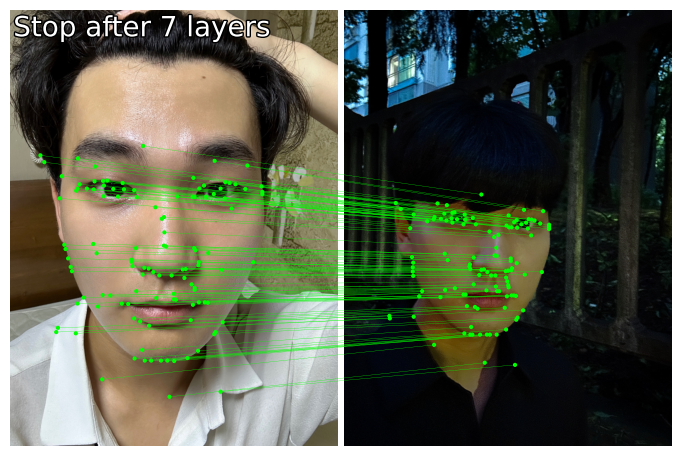

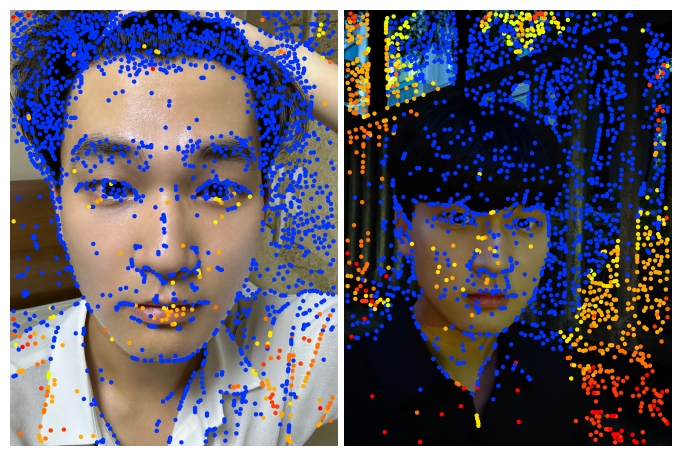

In [9]:
image0 = load_image('/content/drive/MyDrive/my_face/my_face1.JPG')
image1 = load_image('/content/drive/MyDrive/my_face/my_face3.JPG')

feats0 = my_extractor.extract(image0.to(device))
feats1 = my_extractor.extract(image1.to(device))
matches01 = matcher({'image0': feats0, 'image1': feats1})
feats0, feats1, matches01 = [rbd(x) for x in [feats0, feats1, matches01]]  # remove batch dimension

kpts0, kpts1, matches = feats0['keypoints'], feats1['keypoints'], matches01['matches']
m_kpts0, m_kpts1 = kpts0[matches[..., 0]], kpts1[matches[..., 1]]

axes = viz2d.plot_images([image0, image1])
viz2d.plot_matches(m_kpts0, m_kpts1, color='lime', lw=0.2)
viz2d.add_text(0, f'Stop after {matches01["stop"]} layers', fs=20)

kpc0, kpc1 = viz2d.cm_prune(matches01['prune0']), viz2d.cm_prune(matches01['prune1'])
viz2d.plot_images([image0, image1])
viz2d.plot_keypoints([kpts0, kpts1], colors=[kpc0, kpc1], ps=10)

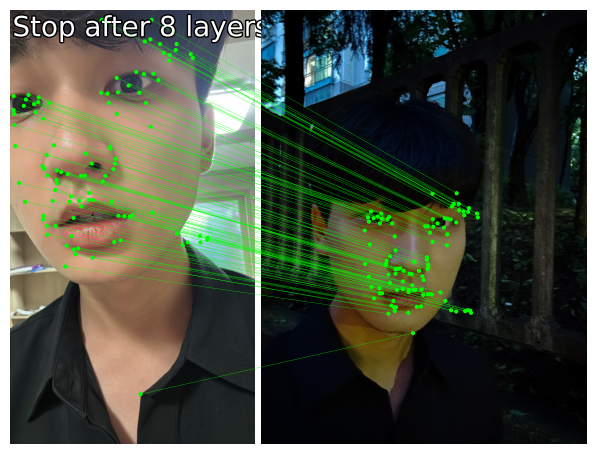

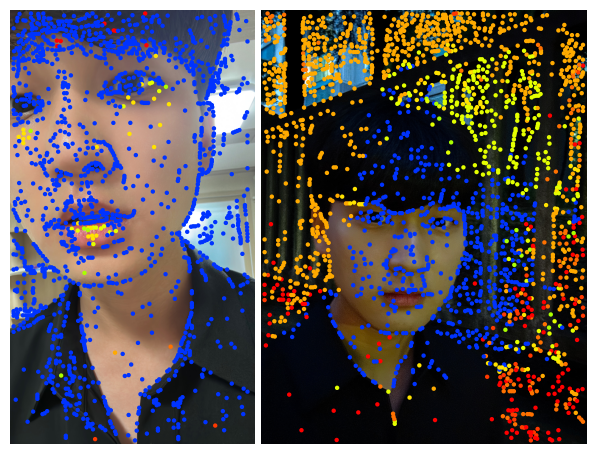

In [10]:
image0 = load_image('/content/drive/MyDrive/my_face/my_face2.JPG')
image1 = load_image('/content/drive/MyDrive/my_face/my_face3.JPG')

feats0 = my_extractor.extract(image0.to(device))
feats1 = my_extractor.extract(image1.to(device))
matches01 = matcher({'image0': feats0, 'image1': feats1})
feats0, feats1, matches01 = [rbd(x) for x in [feats0, feats1, matches01]]  # remove batch dimension

kpts0, kpts1, matches = feats0['keypoints'], feats1['keypoints'], matches01['matches']
m_kpts0, m_kpts1 = kpts0[matches[..., 0]], kpts1[matches[..., 1]]

axes = viz2d.plot_images([image0, image1])
viz2d.plot_matches(m_kpts0, m_kpts1, color='lime', lw=0.2)
viz2d.add_text(0, f'Stop after {matches01["stop"]} layers', fs=20)

kpc0, kpc1 = viz2d.cm_prune(matches01['prune0']), viz2d.cm_prune(matches01['prune1'])
viz2d.plot_images([image0, image1])
viz2d.plot_keypoints([kpts0, kpts1], colors=[kpc0, kpc1], ps=10)